# 时间序列
## 语言
python

## 库
statsmodels

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import os

def getCountByZone(file):
    df = pd.read_excel(file)
    house = df[df['用　　途']=='普通住宅']
    columns = [
        # '所在区县',
        # '成交公司', 
        '成交单价'
    ]
    # groupByZone = house.groupby(['所在区县', '街道(或小区)'])
    groupByZone = house.groupby(['所在区县'])
    # groupByZone[columns].agg(['mean', 'count']).loc[:]
    dict = {}
    for name, group in groupByZone:
        dict[name] = group[columns].agg('count').values[0]
    return dict

data = {}
month = []
for n in range(12):
    month.append('%d月' % (n + 1))
    monthData = getCountByZone('./data/%d.xlsx' % (202000 + (1+n)))
    for zone in monthData:
        arr = data.get(zone, np.zeros(12))
        arr[n] = monthData[zone]
        data[zone] = arr


In [2]:
path = './data/'
arr = []
for file in os.listdir(path):
    df = pd.read_excel('%s/%s' % (path, file))
    house = df[df['用　　途']=='普通住宅']
    arr.append(house)
df = pd.concat(arr)

In [3]:
total = df.groupby('成交时间').agg({'成交单价': 'count'})
total['成交单价'].index

totaldf = pd.DataFrame({ 'key': list(total.index), 'total': list(total.values[:, 0]) })
totaldf

,key,total
0,2020-01-01,29
1,2020-01-02,344
2,2020-01-03,433
3,2020-01-04,56
4,2020-01-05,47
...,...,...
354,2020-12-27,152
355,2020-12-28,862
356,2020-12-29,902
357,2020-12-30,1151


In [4]:
import copy
zones = df.groupby(['所在区县'])
alldf = copy.deepcopy(totaldf)
for name, group in zones:
    z = group.groupby('成交时间').agg({'成交单价': 'count'})
    zonedf = pd.DataFrame({ 'key': list(z.index), name: list(z.values[:, 0]) })	
    alldf = pd.merge(alldf, zonedf, on='key', how='left')
    # alldf.join(zonedf.set_index('key'), on='key')
    # print(alldf.set_index('key').join(zonedf.set_index('key')))
    # alldf.join(zonedf)
    # print(zonedf)
alldf

东城区
丰台区
北京经济技术开发区
大兴区
密云区
平谷区
延庆区
怀柔区
房山区
昌平区
朝阳区
海淀区
石景山区
西城区
通州区
门头沟区
顺义区


,key,total,东城区,丰台区,北京经济技术开发区,大兴区,密云区,平谷区,延庆区,怀柔区,房山区,昌平区,朝阳区,海淀区,石景山区,西城区,通州区,门头沟区,顺义区
0,2020-01-01,29,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,6.0,2.0,6.0,5.0,1.0,2.0,NaN,NaN,1.0
1,2020-01-02,344,6.0,41.0,3.0,22.0,6.0,11.0,11.0,1.0,15.0,23.0,77.0,45.0,21.0,24.0,11.0,15.0,12.0
2,2020-01-03,433,9.0,55.0,3.0,37.0,7.0,5.0,6.0,4.0,26.0,36.0,102.0,55.0,11.0,30.0,27.0,5.0,15.0
3,2020-01-04,56,2.0,9.0,1.0,4.0,2.0,NaN,1.0,1.0,13.0,5.0,5.0,7.0,1.0,1.0,3.0,NaN,1.0
4,2020-01-05,47,1.0,7.0,NaN,6.0,2.0,NaN,NaN,NaN,6.0,2.0,14.0,3.0,1.0,1.0,3.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2020-12-27,152,6.0,6.0,2.0,2.0,1.0,NaN,NaN,5.0,8.0,10.0,64.0,18.0,9.0,9.0,8.0,1.0,3.0
355,2020-12-28,862,35.0,95.0,15.0,52.0,31.0,9.0,6.0,10.0,46.0,58.0,211.0,118.0,28.0,42.0,62.0,12.0,32.0
356,2020-12-29,902,35.0,79.0,9.0,60.0,35.0,8.0,19.0,11.0,48.0,81.0,197.0,143.0,24.0,59.0,52.0,8.0,34.0
357,2020-12-30,1151,50.0,119.0,9.0,65.0,32.0,10.0,13.0,6.0,46.0,106.0,286.0,188.0,35.0,77.0,69.0,14.0,26.0


<AxesSubplot:xlabel='成交时间'>

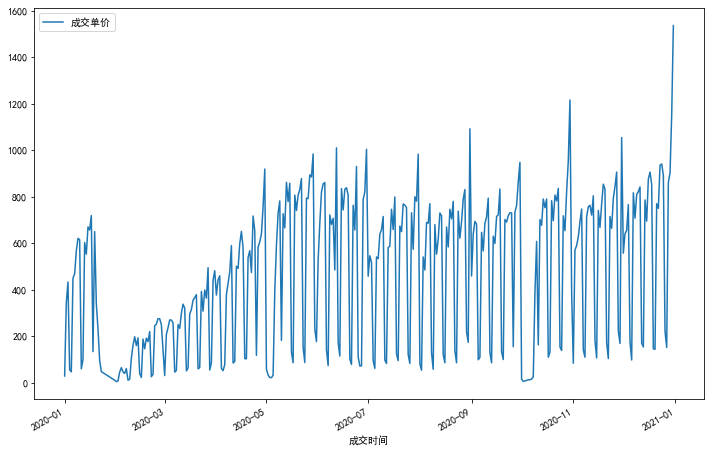

In [5]:
plt.rcParams['font.family'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False
total.plot(figsize=(12,8), label='总数')

In [7]:
alldf['key']

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
354   2020-12-27
355   2020-12-28
356   2020-12-29
357   2020-12-30
358   2020-12-31
Name: key, Length: 359, dtype: datetime64[ns]

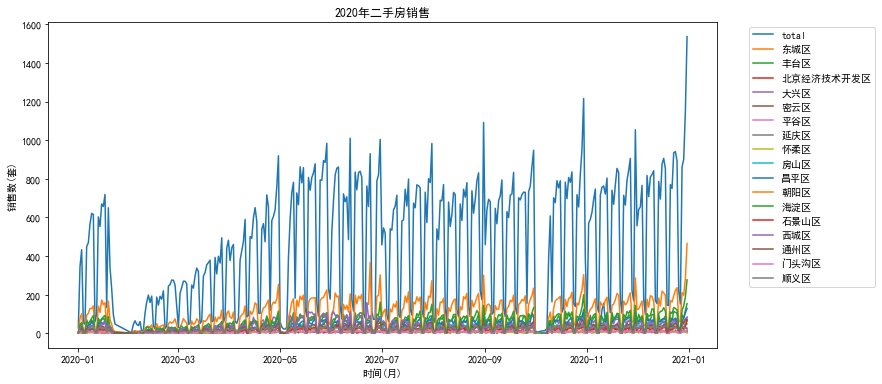

In [10]:
plt.rcParams['font.family'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(15, 6))
x = alldf['key']
for name in alldf.columns:
    if name != 'key':
        ax.plot(x, alldf[name], label=name)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend( bbox_to_anchor=(1.04, 1))
plt.xlabel('时间(月)')
plt.ylabel('销售数(套)')
plt.title('2020年二手房销售')
plt.show()

plt.rcParams['font.family'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(15, 6))
for zone in data:
    ax.plot(month, data[zone], '-o', label=zone)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend( bbox_to_anchor=(1.04, 1))
plt.xlabel('时间(月)')
plt.ylabel('销售数(套)')
plt.title('2020年二手房销售')
plt.show()